<a href="https://colab.research.google.com/github/SergChupin/PyTorch/blob/main/HW_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание
1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 8.2 MB 8.8 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=41acc81827ca0924d4e42820e6911f192f62697bae1015faf033ecfbdddd4269
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=5ce9135d6617029b84311054f5075e7835b2400b85b79d81ceefe78269919080
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built stop-words docopt


In [2]:
import numpy as np
import pandas as pd

from string import punctuation

from pymorphy2 import MorphAnalyzer
import re

from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [363]:
max_words = 2000
max_len = 20
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [364]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [365]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [366]:
test = pd.read_csv('/content/drive/MyDrive/test.csv')
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [367]:
df_train, df_val = train_test_split(train, test_size=0.3, random_state=42)

In [368]:
df_train.head()

,id,label,tweet
9635,9636,0,summer timeð #summeriscoming #swimming #pic...
2447,2448,0,"dese niggas will show dese otha bitches on fb,..."
16134,16135,0,"""when you are you boost your immune system a..."
18393,18394,0,reading my manuscript and not wanting to stop....
4420,4421,0,baby says he hates me today


In [369]:
df_train['label'].value_counts()

0    20815
1     1558
Name: label, dtype: int64

In [370]:
df_val.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


In [371]:
df_val['label'].value_counts()

0    8905
1     684
Name: label, dtype: int64

In [372]:
sw = set(stopwords.words('english'))
# sw

In [373]:
puncts = set(punctuation)
# puncts

In [374]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [375]:
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)
test['tweet'] = test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:03<00:00, 4626.57it/s]


In [376]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [377]:
tokens = word_tokenize(train_corpus)
tokens[:5]

['summer', 'timeð\x9f\x8c', 'summeriscoming', 'swimming', 'picoftheday']

In [378]:
tokens_filtered = [word for word in tokens if word.isalnum()]
# tokens_filtered

In [379]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [380]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'u', 'im', 'life', 'time', 'like']

In [381]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [382]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [383]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in test["tweet"]])

CPU times: user 5.12 s, sys: 14.1 ms, total: 5.14 s
Wall time: 5.15 s


In [384]:
x_train.shape, x_val.shape, x_test.shape

((22373, 20), (9589, 20), (17197, 20))

In [385]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [386]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [387]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


In [388]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [389]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [390]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 271381


In [391]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [392]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.339. Acc: 0.930. Test loss: 0.350. Test acc: 0.929
Epoch [2/10]. Step [44/44]. Loss: 0.230. Acc: 0.930. Test loss: 0.244. Test acc: 0.929
Epoch [3/10]. Step [44/44]. Loss: 0.215. Acc: 0.930. Test loss: 0.245. Test acc: 0.929
Epoch [4/10]. Step [44/44]. Loss: 0.194. Acc: 0.930. Test loss: 0.194. Test acc: 0.929
Epoch [5/10]. Step [44/44]. Loss: 0.170. Acc: 0.937. Test loss: 0.177. Test acc: 0.941
Epoch [6/10]. Step [44/44]. Loss: 0.117. Acc: 0.949. Test loss: 0.189. Test acc: 0.946
Epoch [7/10]. Step [44/44]. Loss: 0.149. Acc: 0.952. Test loss: 0.171. Test acc: 0.944
Epoch [8/10]. Step [44/44]. Loss: 0.144. Acc: 0.954. Test loss: 0.190. Test acc: 0.943
Epoch [9/10]. Step [44/44]. Loss: 0.162. Acc: 0.956. Test loss: 0.141. Test acc: 0.946
Epoch [10/10]. Step [44/44]. Loss: 0.129. Acc: 0.959. Test loss: 0.139. Test acc: 0.948
Training is finished!


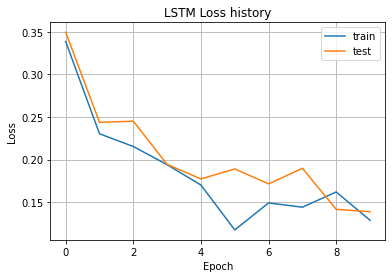

In [393]:
plt.title('LSTM Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

In [394]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU( embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [395]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [396]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [397]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/10]. Step [44/44]. Loss: 0.293. Acc: 0.930. Test loss: 0.281. Test acc: 0.929
Epoch [2/10]. Step [44/44]. Loss: 0.288. Acc: 0.930. Test loss: 0.220. Test acc: 0.929
Epoch [3/10]. Step [44/44]. Loss: 0.189. Acc: 0.930. Test loss: 0.237. Test acc: 0.929
Epoch [4/10]. Step [44/44]. Loss: 0.208. Acc: 0.936. Test loss: 0.151. Test acc: 0.941
Epoch [5/10]. Step [44/44]. Loss: 0.163. Acc: 0.947. Test loss: 0.157. Test acc: 0.945
Epoch [6/10]. Step [44/44]. Loss: 0.169. Acc: 0.952. Test loss: 0.186. Test acc: 0.947
Epoch [7/10]. Step [44/44]. Loss: 0.185. Acc: 0.957. Test loss: 0.138. Test acc: 0.948
Epoch [8/10]. Step [44/44]. Loss: 0.163. Acc: 0.958. Test loss: 0.103. Test acc: 0.949
Epoch [9/10]. Step [44/44]. Loss: 0.092. Acc: 0.961. Test loss: 0.134. Test acc: 0.950
Epoch [10/10]. Step [44/44]. Loss: 0.133. Acc: 0.961. Test loss: 0.136. Test acc: 0.949
Training is finished!


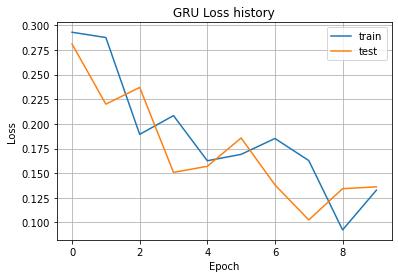

In [398]:
plt.title('GRU Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

Вообще в данном задании результаты были примерно одинаковые, и даже время выполнения отличалось незначительно. В некоторых случаях модели с меньшими параметрами выполнялись дольше, чем модели с бОльшими параметрами.

В итоге я остановился на следующих вводных:

- max_words = 2000
- max_len = 20
- epochs = 10

Выбрал именно такие показатели, т.к. результаты по цифрам и по графикам выглядели наиболее симпатично. 

Однако замечу, что график по LSTM значительно более плавный, чем по GRU. В первом случае это похоже на плавный спуск, а во втором - на горки. Видимо, GRU более чувствительна, что, с одной стороны, позволяет получить результат лучше, а с другой - получить переобучение, и сам результат не так стабилен.